In [8]:
import os, sys, re
import json
import numpy as np
import torch 
from torch.utils.data import Dataset, DataLoader
import polars as pl
from polars import selectors as cs
import pyarrow.feather as feather
from functools import partial
from datasets import Dataset as DSet
from datasets import DatasetDict as DDict
from datasets import concatenate_datasets

import pandas as pd

from scipy.sparse import csr_matrix, coo_matrix

from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, Trainer, TrainingArguments, TextDataset, RobertaForMaskedLM

In [9]:
from sqlalchemy import create_engine, MetaData, Table, select, func
import random

In [10]:
import matplotlib.pyplot as plt

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
from itertools import compress, chain
from collections import defaultdict

In [201]:
from scipy.sparse import triu

In [152]:
combo_matrices_path = r"C:\Users\breuh\OneDrive\proggy\python\MTG\roberta\combo_matrices.pt"
combo_matrices_path = os.path.normpath(combo_matrices_path)

In [155]:
Matrices = torch.load(combo_matrices_path, weights_only=False)

In [157]:
Matrices.keys()

dict_keys(['M', 'y', 'MM', 'MW', 'P', 'cardnames', 'meta'])

In [231]:
M = Matrices['M']
y = Matrices['y']
MM= Matrices['MM']
MW= Matrices['MW']
P = Matrices['P']
cardnames_aligned = Matrices['cardnames']
meta = Matrices['meta']

In [236]:
(M.T@M).max()

np.int32(1144367)

In [238]:
np.float32

numpy.float32

In [237]:
MM.max()

np.float64(0.004999875283663721)

In [13]:
games_folder = r"C:\Users\breuh\OneDrive\proggy\python\MTG\roberta\data_setups\training_database.db"
games_folder = os.path.normpath(games_folder)

In [14]:
print("sqlite:///"+games_folder)

sqlite:///C:\Users\breuh\OneDrive\proggy\python\MTG\roberta\data_setups\training_database.db


In [15]:
engine = create_engine("sqlite:///"+games_folder)
metadata = MetaData()
metadata.reflect(bind=engine)

In [16]:
gamedata_tablename_pattern = re.compile(r"([A-Z]{3})_(\D+)")
gamedata_tablenames = list(filter(gamedata_tablename_pattern.match, metadata.tables.keys()))

gamedata_tablenames

['BRO_Sealed',
 'BRO_TradSealed',
 'DFT_Sealed',
 'DFT_TradSealed',
 'KHM_PremierDraft',
 'KTK_Sealed',
 'KTK_TradSealed',
 'LCI_Sealed',
 'LCI_TradSealed',
 'LTR_PremierDraft',
 'LTR_Sealed',
 'LTR_TradSealed',
 'MKM_Sealed',
 'MKM_TradSealed',
 'MOM_Sealed',
 'MOM_TradSealed',
 'NEO_Sealed',
 'ONE_Sealed',
 'ONE_TradSealed',
 'PIO_Sealed',
 'SIR_Sealed',
 'SIR_TradSealed',
 'SNC_TradSealed',
 'WOE_PremierDraft',
 'WOE_Sealed',
 'WOE_TradSealed']

In [17]:
scryfall_table = metadata.tables['scryfall_pruned']

query = select(scryfall_table.c.name).where(scryfall_table.c.type_line.ilike('%basic land%'))
with engine.connect() as conn:
    land_names = conn.execute(query).fetchall()
land_names = [x[0] for x in land_names]

In [213]:
p0 = y.mean()
k = 200
alpha0, beta0 = p0*k, (1-p0)*k
def smooth(w, n): return (w+alpha0)/(n+alpha0+beta0)
def logit(p, eps=1e-9): p=np.clip(p,eps,1-eps); return np.log(p) - np.log1p(-p)
def sigmoid(z): return 1/(1+np.exp(-z))

In [222]:
def smooth_(MW_, MM_, alpha0=alpha0, beta0=beta0):
    MW_.data = MW_.data * alpha0
    MW_ = MW_.tocsr()
    MM_.data = np.divide(1, MM_.data+alpha0+beta0,
                         out=np.zeros_like(MM_.data, dtype=float),
                         where=MM_.data != 0)
    MM_ = MM_.tocsr()
    print(MM_.max(), MW.max())
    return MW_.multiply(MM_)

Psmooth = smooth_(MW, MM)

0.004999875283663721 3.376289788506137e+19


In [230]:
M.max()

np.int32(1)

In [228]:
(M.T @ (M.multiply(y.reshape(-1, 1))).tocsr()).max()

np.int32(641601)

In [220]:
Psmooth_triu = triu(Psmooth, k=1)
P_triu = triu(P, k=1)

In [221]:
Psmooth_triu.max(), P_triu.max()

(np.float64(612505985790633.8), np.float64(1.0))

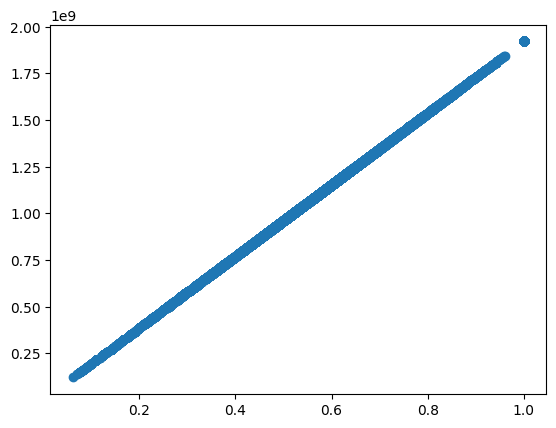

In [216]:
plt.scatter(P_triu.data, Psmooth_triu.data)

In [19]:
# singles
n_i = np.asarray(M.sum(axis=0)).ravel()
w_i = np.asarray((M.multiply(y.reshape(-1, 1))).sum(axis=0)).ravel()
p_i = w_i/n_i
p_i = np.nan_to_num(p_i, nan=0)

# pairs (upper triangle later)
n_ij = (M.T @ M).tocoo()
w_ij = (M.T @ (M.multiply(y.reshape(-1, 1)))).tocoo()

# align w_ij to n_ij
w_lookup = {(r, c): v for r, c, v in zip(w_ij.row, w_ij.col, w_ij.data)}

p0 = y.mean()
k = 50
alpha0, beta0 = p0*k, (1-p0)*k
def smooth(w, n): return (w+alpha0)/(n+alpha0+beta0)
def logit(p, eps=1e-9): p=np.clip(p,eps,1-eps); return np.log(p) - np.log1p(-p)
def sigmoid(z): return 1/(1+np.exp(-z))

C:\Users\breuh\AppData\Local\Temp\ipykernel_12036\1897118090.py:4: RuntimeWarning: invalid value encountered in divide
  p_i = w_i/n_i


In [23]:
n_i

array([ 2244,   275,  3897, ...,  9231,  9505, 21195], shape=(4147,))

In [32]:
p_i_smooth = smooth(w_i, n_i)

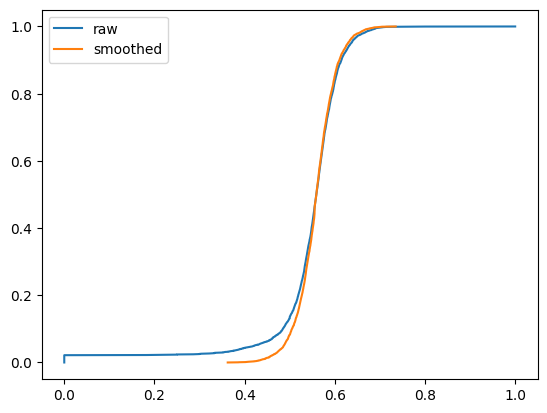

In [33]:
plt.plot(sorted(p_i), np.linspace(0, 1, len(p_i)), label='raw')
plt.plot(sorted(p_i_smooth), np.linspace(0, 1, len(p_i)), label='smoothed')

plt.legend(loc='upper left')

(0.0, 1.0)

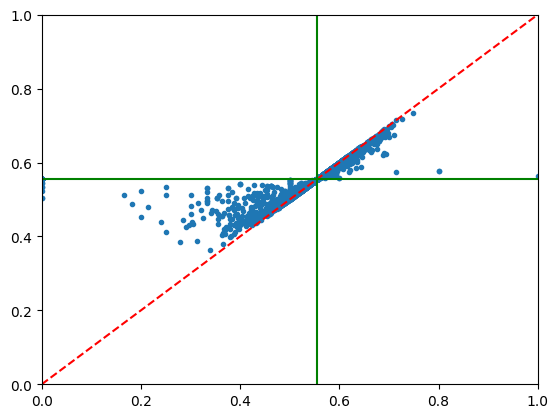

In [34]:
plt.scatter(p_i, p_i_smooth, marker='.')
plt.plot([0,1],[0,1],'r--')
plt.hlines(p0,0,1,'g')
plt.vlines(p0,0,1,'g')

plt.ylim(0,1)
plt.xlim(0,1)

In [85]:
p0 = y.mean()
p0.item()

0.5550307307594493

In [73]:
rows = n_ij.row
cols = n_ij.col
nij = n_ij.data
wij = np.array([w_lookup.get((r,c), 0) for r,c in zip(rows,cols)])
p_ij = wij/nij

In [74]:
# keep only upper triangle and support cutoff
mask = (rows < cols) & (nij >= 100)   # min support = 100
rows = rows[mask]
cols = cols[mask]
nij = nij[mask]
wij = wij[mask]


In [76]:
# observed smoothed winrate
p_ij = smooth(wij, nij)

# expected under no-interaction baseline
p_i_sel = p_i_smooth[rows]
p_j_sel = p_i_smooth[cols]
p_ij_no_interaction = sigmoid(logit(p_i_sel) + logit(p_j_sel) - logit(p0))

In [77]:
# synergy metrics
lift = p_ij / p_no
delta = logit(p_ij) - logit(p_no)

# --- assemble results ---
results = np.rec.fromarrays(
    [rows, cols, nij, wij, p_ij, p_ij_no_interaction, lift, delta],
    names=['i','j','n_games','n_wins','p_ij','p_no_int','lift','delta_logit']
)

In [ ]:
df_results = pl.DataFrame(results)

i,j,n_games,n_wins,p_ij,p_no_int,lift,delta_logit
i32,i32,i64,i64,f64,f64,f64,f64
14,16,115,76,0.628797,0.600983,1.046281,0.117498
5,16,127,76,0.586167,0.615379,0.95253,-0.121839
15,17,120,78,0.622068,0.642012,0.968935,-0.085772
5,18,308,190,0.608245,0.614974,0.989058,-0.028329
17,18,216,135,0.611848,0.658951,0.928518,-0.203536
…,…,…,…,…,…,…,…
2585,4146,214,147,0.661938,0.65525,1.010206,0.029742
1362,4146,1231,707,0.573577,0.567427,1.010838,0.025099
1065,4146,813,510,0.623119,0.570342,1.092535,0.21956


In [47]:
pairs = {}
for i, j, nij in zip(n_ij.row, n_ij.col, n_ij.data):
    if i >= j:
        continue
    w_ij_val = w_lookup.get((i, j), 0)
    p_ij_smooth = smooth(w_ij_val, nij)
    
    p_ij_no_interaction = sigmoid(logit(p_i_smooth[i]) + logit(p_i_smooth[j]) - logit(p0))
    lift = p_ij_smooth / p_ij_no_interaction
    dlog = logit(p_ij_smooth) - logit(p_ij_no_interaction)
    pairs[(i.item(),j.item())] = {'n': nij, 'w': w_ij_val, 'p_ij_smooth': p_ij_smooth, 'p_ij_no_interaction': p_ij_no_interaction, 'lift': lift, 'dlog': dlog}

In [50]:
df_combos = pl.from_dicts(list(pairs.values()))

In [64]:
df_combos_filtered = df_combos.filter((pl.col('n') >= 2*k) )

In [68]:
X = df_combos_filtered.select(pl.col('p_ij_smooth'), pl.col('p_ij_no_interaction')).to_numpy()

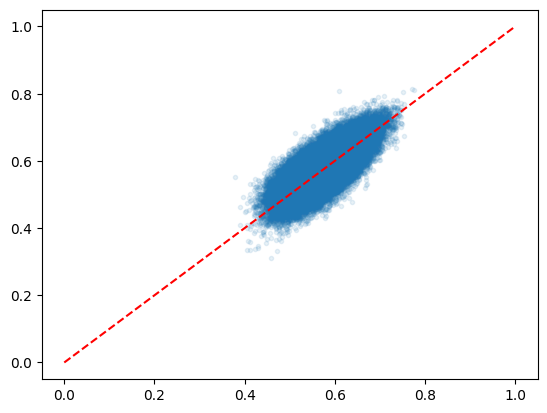

In [69]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], marker='.', alpha=0.1)
ax.plot([0,1],[0,1],'r--')